# Machine Learning Engineer Nanodegree
### *Capstone Project (Airbnb New User Bookings)*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime, date
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import display
import gc
import xgboost as xgb
import operator

# Draw inline
%matplotlib inline
# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 7.0})
sns.set_context("poster", font_scale=0.4)

## Set file paths

I have not used `sessions`, `age_gender_bkts` and `countries` files.

In [2]:
train_users_path = 'data/train_users_2.csv'
test_users_path = 'data/test_users.csv'

## Data Loading

In [3]:
# Load the data into DataFrames

# train_users
train_users = pd.read_csv(train_users_path)
target = train_users['country_destination']
train_users = train_users.drop(['country_destination'], axis=1)

# test_users
test_users = pd.read_csv(test_users_path)

In [4]:
display(train_users.head())
display(test_users.head())

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [5]:
# Combine train and test dataset for cleaning
users = pd.concat((train_users, test_users), axis=0, ignore_index=True)

print "Number of rows, columns in users dataframe: " + str(users.shape)

display(users.head())

Number of rows, columns in users dataframe: (275547, 15)


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


## Data Exploration

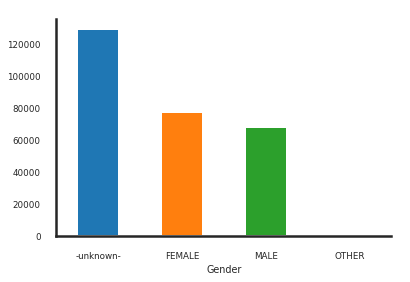

In [6]:
users.gender.value_counts(dropna=False).plot(kind='bar', rot=0)
plt.xlabel('Gender')
sns.despine()

[Text(0,0.5,'frequency'), Text(0.5,0,'countries')]

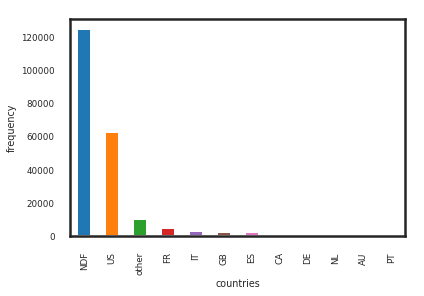

In [7]:
target.value_counts().plot(kind='bar').set(xlabel='countries', ylabel='frequency')

## Clean dataset

We will replace missing values with and -unknown- values with -1

In [8]:
# Display percentage of missing data
display((users.isnull().sum() / users.shape[0]) * 100)
display((test_users.isnull().sum() / test_users.shape[0]) * 100)
display((train_users.isnull().sum() / train_users.shape[0]) * 100)

id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         67.733998
gender                      0.000000
age                        42.412365
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.208335
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
dtype: float64

id                           0.000000
date_account_created         0.000000
timestamp_first_active       0.000000
date_first_booking         100.000000
gender                       0.000000
age                         46.502190
signup_method                0.000000
signup_flow                  0.000000
language                     0.000000
affiliate_channel            0.000000
affiliate_provider           0.000000
first_affiliate_tracked      0.032208
signup_app                   0.000000
first_device_type            0.000000
first_browser                0.000000
dtype: float64

id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         58.347349
gender                      0.000000
age                        41.222576
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.841402
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
dtype: float64

In [9]:
users.index = users.id
users = users.fillna(-1)
users = users.replace('-unknown-', -1)

display(users.head())

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
id,,,,,,,,,,,,,,,
gxn3p5htnn,gxn3p5htnn,2010-06-28,20090319043255,-1,-1,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
820tgsjxq7,820tgsjxq7,2011-05-25,20090523174809,-1,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
4ft3gnwmtx,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
bjjt8pjhuk,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
87mebub9p4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-1,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


Date of first booking is surprisingly missing in the test dataset and would reduce the validity of our classifiers we build. So I have decided to drop it.

In [10]:
users = users.drop(['date_first_booking'], axis=1)

## Remove erroneous ages

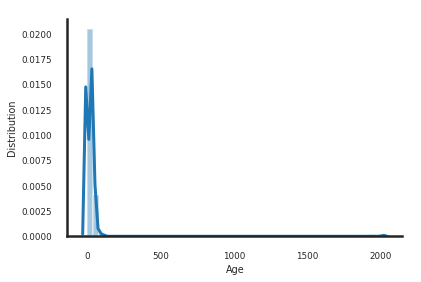

In [11]:
sns.distplot(users.age.dropna())
plt.xlabel('Age')
plt.ylabel('Distribution')
sns.despine()

In [12]:
# Remove users with 
users.age.loc[users.age < 15] = np.nan
users.age.loc[users.age > 100] = np.nan

/home/fractaluser/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


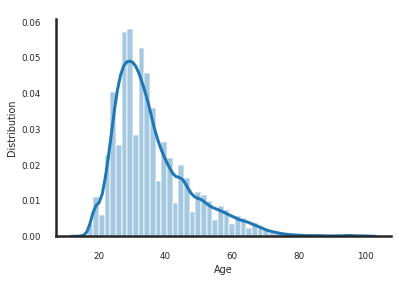

In [13]:
sns.distplot(users.age.dropna())
plt.xlabel('Age')
plt.ylabel('Distribution')
sns.despine()

In [14]:
users.age.describe()

count    155932.000000
mean         36.055043
std          11.663664
min          15.000000
25%          28.000000
50%          33.000000
75%          42.000000
max         100.000000
Name: age, dtype: float64

## Creating Features and OHE
(Reference Link: https://www.kaggle.com/svpons/feature-engineering)

In [15]:
#(One-hot encoding of the age according these intervals)
interv =  [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100]
def get_interv_value(age):
    iv = 20
    for i in range(len(interv)):
        if age < interv[i]:
            iv = i 
            break
    return iv
users['age_interv'] = users.age.apply(lambda x: get_interv_value(x))
users_ai = pd.get_dummies(users.age_interv, prefix='age_interv')
users = users.drop(['age_interv'], axis=1)
users = pd.concat((users, users_ai), axis=1)


In [16]:
#date_account_created
dac = np.vstack(users.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
users['dac_y'] = dac[:,0]
users['dac_m'] = dac[:,1]
users['dac_d'] = dac[:,2]
dac_dates = [datetime(x[0],x[1],x[2]) for x in dac]
users['dac_wn'] = np.array([d.isocalendar()[1] for d in dac_dates])
users['dac_w'] = np.array([d.weekday() for d in dac_dates])
users_wd = pd.get_dummies(users.dac_w, prefix='dac_w')
users = users.drop(['date_account_created', 'dac_w'], axis=1)
users = pd.concat((users, users_wd), axis=1)

In [17]:
#timestamp_first_active
tfa = np.vstack(users.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
users['tfa_y'] = tfa[:,0]
users['tfa_m'] = tfa[:,1]
users['tfa_d'] = tfa[:,2]
users['tfa_h'] = tfa[:,3]
tfa_dates = [datetime(x[0],x[1],x[2],x[3],x[4],x[5]) for x in tfa]
users['tfa_wn'] = np.array([d.isocalendar()[1] for d in tfa_dates])
users['tfa_w'] = np.array([d.weekday() for d in tfa_dates])
users_wd = pd.get_dummies(users.tfa_w, prefix='tfa_w')
users = users.drop(['timestamp_first_active', 'tfa_w'], axis=1)
users = pd.concat((users, users_wd), axis=1)

In [18]:
#Comptute seasons from dates
#(Computing the season for the two dates)
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [(0, (date(Y,  1,  1),  date(Y,  3, 20))),  #'winter'
           (1, (date(Y,  3, 21),  date(Y,  6, 20))),  #'spring'
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),  #'summer'
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),  #'autumn'
           (0, (date(Y, 12, 21),  date(Y, 12, 31)))]  #'winter'
def get_season(dt):
    dt = dt.date()
    dt = dt.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= dt <= end)
users['season_dac'] = np.array([get_season(dt) for dt in dac_dates])
users['season_tfa'] = np.array([get_season(dt) for dt in tfa_dates])

In [19]:
#One-hot-encoding features
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    users_dummy = pd.get_dummies(users[f], prefix=f)
    users = users.drop([f], axis=1)
    users = pd.concat((users, users_dummy), axis=1)   

In [20]:
display(users.head())

,id,age,age_interv_4,age_interv_5,age_interv_6,age_interv_7,age_interv_8,age_interv_9,age_interv_10,age_interv_11,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,gxn3p5htnn,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
820tgsjxq7,820tgsjxq7,38.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4ft3gnwmtx,4ft3gnwmtx,56.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bjjt8pjhuk,bjjt8pjhuk,42.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
87mebub9p4,87mebub9p4,41.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
users = users.drop(['id'], axis=1)

In [22]:
users = users.fillna(-1)

## Checkpoint

In [23]:
# Save as
users.to_pickle('users_checkpoint1')

In [24]:
# Uncomment to Load from Checkpoint
users = pd.read_pickle('users_checkpoint1')

# NDCG Scoring Function
Reference: https://www.kaggle.com/dietcoke/score-predictions-using-ndcg

In [25]:
def dcg_at_k(r, k, method=1):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k=5, method=1):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


def score_predictions(preds, truth, n_modes=5):
    """
    preds: pd.DataFrame
      one row for each observation, one column for each prediction.
      Columns are sorted from left to right descending in order of likelihood.
    truth: pd.Series
      one row for each obeservation.
    """
    assert(len(preds)==len(truth))

    r = pd.DataFrame(0, index=preds.index, columns=preds.columns, dtype=np.float64)
    for col in preds.columns:
        r[col] = (preds[col] == truth) * 1.0

    score = pd.Series(r.apply(ndcg_at_k, axis=1, reduce=True), name='score')
    return score.mean()

In [26]:
"""Metrics to compute the model performance."""
# ref: https://www.kaggle.com/davidgasquez/airbnb-recruiting-new-user-bookings/ndcg-scorer
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.
        
    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    #lb.fit(range(len(predictions) + 1))  ## original
    #lb.fit(range(predictions.shape[1] + 1))
    #T = lb.transform(ground_truth)
    
    T = lb.fit_transform(ground_truth) 

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

# Naive Benchmark Model

We will test the model where the model predicts [NDF, US, Other, FR, IT] which are the five most frequent according to our analysis in Data Exploration above.

In [27]:
piv_train = len(target) #Marker to split users into train + test
vals = users.values

X = vals[:piv_train]
y = target.values

truth = pd.Series(y)
preds = []

for i in range(len(X)):
    preds += [['NDF', 'US', 'other', 'FR', 'IT']]

preds = pd.DataFrame(preds)
print "Score for Benchmark Model: " + str(score_predictions(preds, truth))

/home/fractaluser/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: FutureWarning: The reduce argument is deprecated and will be removed in a future version. You can specify result_type='reduce' to try to reduce the result to the original dimensions


Score for Benchmark Model: 0.8067654420381531


In [28]:
# Create Submission

id_test = test_users['id']

# Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += ['NDF', 'US', 'other', 'FR', 'IT']

sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('benchmark_naive.csv',index=False)

This model achieves:
- Validation Score: 0.806765442038

This kind of classification task works nicely with tree-based methods, I will use Random Forest and xgboost to make the probabilities predictions below

# Random Forest

In [29]:
# Uncomment to Load from Checkpoint
users = pd.read_pickle('users_checkpoint1')

In [30]:
#Split data back into train and test sets
vals = users.values
piv_train = len(target)
X = vals[:piv_train]
X_test = vals[piv_train:]

# Create numeric label for each of the 12 target labels
labels = target.values
le = LabelEncoder()
y = le.fit_transform(labels)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(n_estimators=25, random_state=101)
parameters = {'min_samples_split': [2, 20],
              'max_depth': [6, 8]
             }

reg = GridSearchCV(clf, parameters, scoring=ndcg_scorer, cv=3)

reg.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=101, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 20], 'max_depth': [6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(ndcg_score, needs_proba=True, k=5), verbose=0)

In [32]:
est = reg.best_estimator_
est

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

In [33]:
y_pred = est.predict_proba(X)

truth = pd.Series(le.inverse_transform(y))
preds = []

for i in range(len(X)):
    preds += [le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()]

preds = pd.DataFrame(preds)
print "Score for Random Forrest: " + str(score_predictions(preds, truth))


/home/fractaluser/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: FutureWarning: The reduce argument is deprecated and will be removed in a future version. You can specify result_type='reduce' to try to reduce the result to the original dimensions


Score for Random Forrest: 0.8175642777261806


In [34]:
# make predictions on test set
ypred = est.predict_proba(X_test)
id_test = test_users['id']
# Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('random_forrest.csv',index=False)

This model achieves:
- Validation Score: 0.81756

Hence, we can see that RandomForest is able to achieve a slightly better score than our benchmark model.

# XGBoost

Tests were performed with vanilla XGBoost over all the columns, this resulted in our model taking more than an hour to train. Since, I had limited computing resources, I stopped the training after 1 hour. I will now proceed with reducing the number of features using finding feature importances with parameters that end training fast.

## Feature Importances
Reference: https://www.kaggle.com/kevinwu06/feature-importance-w-xgboost

In [35]:
from sklearn.model_selection import train_test_split

piv_train = len(target) #Marker to split users into train + test
vals = users.values
le = LabelEncoder()

X = vals[:piv_train]
y = le.fit_transform(target.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_test_set = vals[piv_train:]

In [36]:
# XGB Classifier Parameters
params = {'eta': 0.2,
          'max_depth': 6,
          'subsample': 0.5,
          'colsample_bytree': 0.5,
          'objective': 'multi:softprob',
          'num_class': 12}

In [37]:
# First train on whole training set for feature importances
num_boost_round = 1
dtrain = xgb.DMatrix(X, y)
clf1 = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round)

# Get feature scores and store in DataFrame
importance = clf1.get_fscore()
importance_df = pd.DataFrame(
    sorted(importance.items(), key=operator.itemgetter(1)), 
    columns=['feature','fscore']
    )

[11:16:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[11:16:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[11:16:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[11:16:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[11:16:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[11:16:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[11:16:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[11:16:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[11:16:11] /wor

In [38]:
top_features = [users.columns[int(i.split('f')[1])] for i in importance_df.iloc[-30:,:].feature.values]

display(top_features)

['age_interv_5',
 'first_device_type_iPad',
 'language_es',
 'season_dac',
 'signup_flow_1',
 'first_device_type_Android Tablet',
 'age_interv_20',
 'gender_FEMALE',
 'affiliate_provider_google',
 'affiliate_channel_sem-non-brand',
 'tfa_y',
 'tfa_w_5',
 'first_browser_Firefox',
 'signup_method_facebook',
 'signup_method_basic',
 'affiliate_channel_content',
 'dac_m',
 'signup_flow_0',
 'first_device_type_Other/Unknown',
 'first_affiliate_tracked_untracked',
 'gender_-1',
 'first_device_type_Mac Desktop',
 'tfa_d',
 'signup_flow_3',
 'dac_d',
 'tfa_h',
 'tfa_wn',
 'dac_y',
 'age',
 'dac_wn']

In [39]:
importance_df.feature = [users.columns[int(i.split('f')[1])] for i in importance_df.feature.values]

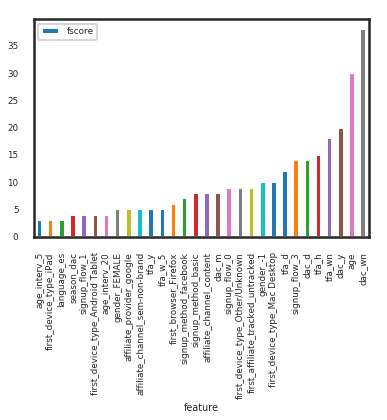

In [40]:
# Plot feature importance of top 30
importance_df.iloc[-30:,:].plot(x='feature',y='fscore',kind='bar')

In [41]:
# Now train on X_train, y_train and get NDCG Score
# Only select features w/ a feature score in top 20
# And Retrain model with reduced feature set
users_clf2 = users[top_features]

vals = users_clf2.values
le = LabelEncoder()

X = vals[:piv_train]
y = le.fit_transform(target.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

dtrain = xgb.DMatrix(X_train, y_train)
clf2 = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round)

y_pred = clf2.predict(xgb.DMatrix(X_test))

[11:16:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:16:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[11:16:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[11:16:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[11:16:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[11:16:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[11:16:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[11:16:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[11:16:15] /wor

In [42]:
truth = pd.Series(le.inverse_transform(y_test))
preds = []

for i in range(len(X_test)):
    preds += [le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()]

preds = pd.DataFrame(preds)
print "Score for XGBoost using top 30 features: " + str(score_predictions(preds, truth))


/home/fractaluser/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: FutureWarning: The reduce argument is deprecated and will be removed in a future version. You can specify result_type='reduce' to try to reduce the result to the original dimensions


Score for XGBoost using top 30 features: 0.8161605259020948


In [43]:
# Submission

id_test = test_users['id']

users_clf3 = users[top_features]

vals = users_clf3.values
le = LabelEncoder()

X = vals[:piv_train] 
y = le.fit_transform(target.values)
X_test = vals[piv_train:]

dtrain = xgb.DMatrix(X, y)
clf3 = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round)

y_pred = clf3.predict(xgb.DMatrix(X_test))

# Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('submission_xgb_feature_importance.csv',index=False)

[11:16:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[11:16:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[11:16:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[11:16:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[11:16:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[11:16:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[11:16:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[11:16:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[11:16:28] /wor

This model achieves:
- Validation Score of 0.81616

This is more than our benchmark as well our test with RandomForest, hence feature selection seems to be showing a good improvement.

### XGBoost with objective as rank:pairwise
Reference: https://github.com/davidgasquez/kaggle-airbnb/blob/master/scripts/generate_submission.py

In [44]:
from xgboost.sklearn import XGBClassifier

clf_rp = XGBClassifier(
        max_depth=7,
        learning_rate=0.18,
        n_estimators=80,
        objective="rank:pairwise",
        gamma=0,
        min_child_weight=1,
        max_delta_step=0,
        subsample=1,
        colsample_bytree=1,
        colsample_bylevel=1,
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        base_score=0.5,
        missing=None,
        silent=True,
        nthread=-1,
        seed=42
    )

users_clf_rp = users[top_features]

vals = users_clf_rp.values
le = LabelEncoder()

X = vals[:piv_train]
y = le.fit_transform(target.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf_rp.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.18, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=80,
       n_jobs=1, nthread=-1, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [45]:
y_pred = clf_rp.predict_proba(X_test)

truth = pd.Series(le.inverse_transform(y_test))
preds = []

for i in range(len(X_test)):
    preds += [le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()]

preds = pd.DataFrame(preds)
print "Score for XGBoost(RankPairwise) using top 30 features: " + str(score_predictions(preds, truth))


/home/fractaluser/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: FutureWarning: The reduce argument is deprecated and will be removed in a future version. You can specify result_type='reduce' to try to reduce the result to the original dimensions


Score for XGBoost(RankPairwise) using top 30 features: 0.8236973542213447


In [46]:
# Submission

id_test = test_users['id']

users_clf_rp = users[top_features]

vals = users_clf_rp.values
le = LabelEncoder()

X = vals[:piv_train] 
y = le.fit_transform(target.values)
X_test_set = vals[piv_train:]

clf_rp.fit(X,y)

y_pred = clf_rp.predict_proba(X_test_set)

# Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('submission_xgb_rp.csv',index=False)

This model achieves:
- Validation Score of 0.82369

This is more than our previous tests, rank:pairwaise was a good objective for XGBoost.

In [47]:
ids = []  #list of ids
cts = []  #list of countries
id_test = test_users['id']
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx]
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:1].tolist()

sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

[Text(0,0.5,'frequency'), Text(0.5,0,'country')]

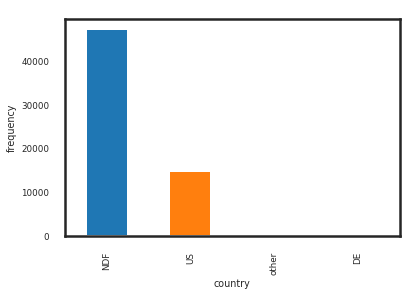

In [48]:
sub.country.value_counts().plot(kind='bar').set(xlabel='country', ylabel='frequency')